In [1]:
import matplotlib.pyplot as plt
import pandas 
import numpy
import re
import pickle

In [2]:
lll =[4,6,6,1,2,3,5,6,6,6,5,6,6,6,6]
print(numpy.median(lll), numpy.mean(lll))

6.0 4.933333333333334


# Important Functions

In [11]:
def read_goodlist(coin_timeframe):
  with open(f"backtest_result/goodlist_{coin_timeframe}.pkl","rb") as file:
    result = pickle.load(file, encoding='bytes')
    print('read_goodlist:', result)
    return result

def save_goodlist(result, coin_timeframe):
  with open(f"backtest_result/goodlist_{coin_timeframe}.pkl","wb") as file:
    pickle.dump(result, file)

def get_config_list_from_backtest_summary(backtest_summary):
  config_list = backtest_summary[['config_length', 'config_multiplier']]
  return config_list.values.tolist()

def save_in_pkl(data, path):
  with open(path,"wb") as file:
    pickle.dump(data, file)

def load_from_pkl(path):
  with open(path,"rb") as file:
    result = pickle.load(file, encoding='bytes')
    return result

class GoodList():
  def __init__(self, length=10):
    self.toplist = {'key':numpy.zeros(length), 'value':numpy.zeros(length)}
    self.threshold = 0
    self.count = 0
    self.length = length

  def push(self, key, value):
    if (value > self.threshold or self.count < self.length):
      min_index = numpy.argmin(self.toplist['value'])
      self.toplist['key'][min_index] = key
      self.toplist['value'][min_index] = value

      self.threshold = value
      self.count += 1
      
def plot1(df, coin_timeframe):
  df['balance_std'] = (df['balance'] - df['balance'].mean()) / df['balance'].std()

  # Plot balances distribution against Length and Multiplier 
  balance_for_lengths = []
  balance_for_multipliers = []
  max_for_lengths = 0
  max_for_multipliers = 0
  kinda_best_length = 0
  kinda_best_multiplier = 0
  
  # Length
  goodlist_length = GoodList()
  for length in range(4,21):
    balance_for_each_length = list(df[df['config_length'].values == length]['balance'])
    # Record set of balances for each length
    balance_for_lengths.append(balance_for_each_length)
    # Calculate risk-adjusted return for choosing kinda_best_length
    median_return = numpy.median(balance_for_each_length)
    std = numpy.std(balance_for_each_length)
    riskadjusted_return = median_return/std
    goodlist_length.push(length, riskadjusted_return)

    if (riskadjusted_return > max_for_lengths):
      kinda_best_length = length
      max_for_lengths = riskadjusted_return

  fig = plt.figure(figsize=[24, 8])
  ax = fig.add_subplot(1, 2, 1)
  ax.boxplot(balance_for_lengths);
  ax.set_xticklabels(range(4,21))
  ax.set_title('Balance vs. Length')

  # Multiplier
  goodlist_multiplier = GoodList()
  for multiplier in numpy.arange(4,20.5,0.5):
    balance_for_each_multiplier = list(df[df['config_multiplier'].values == multiplier]['balance'])
    # Record set of balances for each multiplier
    balance_for_multipliers.append(balance_for_each_multiplier)
    # Calculate risk-adjusted return for choosing kinda_best_multiplier
    median_return = numpy.median(balance_for_each_multiplier)
    std = numpy.std(balance_for_each_multiplier)
    riskadjusted_return = median_return/std
    goodlist_multiplier.push(multiplier, riskadjusted_return)

    if (riskadjusted_return > max_for_multipliers):
      kinda_best_multiplier = multiplier
      max_for_multipliers = riskadjusted_return

  ax = fig.add_subplot(1, 2, 2)
  ax.boxplot(balance_for_multipliers);
  ax.set_xticklabels(numpy.arange(4,20.5,0.5))
  ax.set_title('Balance vs. Multiplier')


  # Plot pnl amounts histogram for TOP lengths and multipliers
  print('goodlist_length:',goodlist_length.toplist['key'])
  print('goodlist_multiplier:',goodlist_multiplier.toplist['key'])
  profit_amounts = []
  loss_amounts = []
  for multiplier in goodlist_multiplier.toplist['key']:
    for length in goodlist_length.toplist['key']:
      # print(length,multiplier)
      df2 = df.query(f"config_length=={length} & config_multiplier=={multiplier}").copy()
      profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", df2.iloc[0].profit_amounts).split(',')
      loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", df2.iloc[0].loss_amounts).split(',')

  profit_amounts = [float(x) for x in profit_amounts]
  loss_amounts = [float(x) for x in loss_amounts]

  fig = plt.figure(figsize=[20, 14])
  ax = fig.add_subplot(2, 1, 1)
  ax.hist(profit_amounts, 101);
  # ax.set_xticks(range(0,600,20))  #
  ax.set_title('Profits distribution')

  ax = fig.add_subplot(2, 1, 2)
  ax.hist(loss_amounts, 101);
  # ax.set_xticks(range(0,600,20))
  ax.set_title('Losses distribution')


  # Plot pnl amounts histogram just for best length and multiplier
  profit_amounts = []
  loss_amounts = []
  df2 = df.query(f"config_length=={kinda_best_length} & config_multiplier=={kinda_best_multiplier}").copy()
  print(f"kinda_best_length = {kinda_best_length};\tkinda_best_multiplier = {kinda_best_multiplier}")
  print(df2[['average_profit','average_loss']])
  # Convert strings to list
  profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", df2.iloc[0].profit_amounts).split(',')
  loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", df2.iloc[0].loss_amounts).split(',')
  # Convert int to float
  profit_amounts = [float(x) for x in profit_amounts]
  loss_amounts = [float(x) for x in loss_amounts]

  fig = plt.figure(figsize=[20, 14])
  ax = fig.add_subplot(2, 1, 1)
  ax.hist(profit_amounts, 101);
  # ax.set_xticks(range(0,600,20))  #
  ax.set_title('Profits distribution')

  ax = fig.add_subplot(2, 1, 2)
  ax.hist(loss_amounts, 101);
  # ax.set_xticks(range(0,600,20))
  ax.set_title('Losses distribution')

  return { 
      'coin_timeframe': coin_timeframe,
      'kinda_best_length': kinda_best_length,
      'kinda_best_multiplier': kinda_best_multiplier,
      'good_length_list': goodlist_length.toplist['key'],
      'good_multiplier_list': goodlist_multiplier.toplist['key'],
    }


## BTC 15m


goodlist_length: [ 4.  5.  6.  7.  8.  9. 10. 14. 12. 13.]
goodlist_multiplier: [ 9.  10.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5]
kinda_best_length = 6;	kinda_best_multiplier = 10.5
    average_profit  average_loss
79       15.765387     -5.449026
read_goodlist: {'coin_timeframe': 'btc_15m', 'kinda_best_length': 6, 'kinda_best_multiplier': 10.5, 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 14., 12., 13.]), 'good_multiplier_list': array([ 9. , 10.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5])}


{'coin_timeframe': 'btc_15m',
 'kinda_best_length': 6,
 'kinda_best_multiplier': 10.5,
 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 14., 12., 13.]),
 'good_multiplier_list': array([ 9. , 10.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5])}

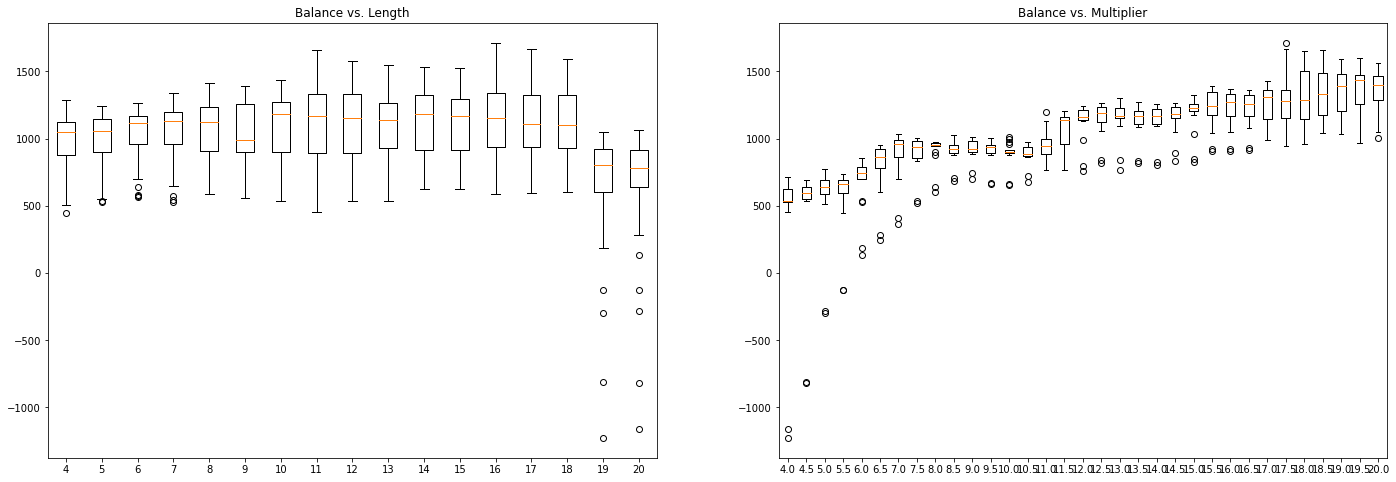

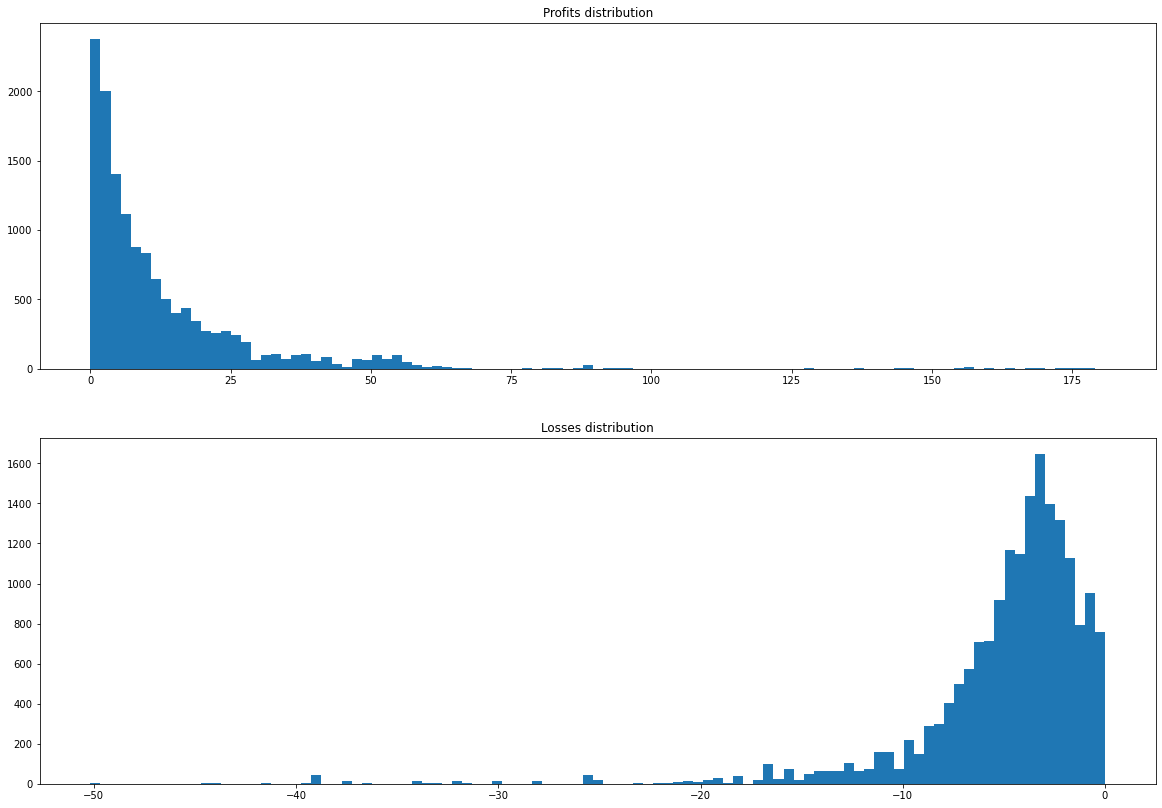

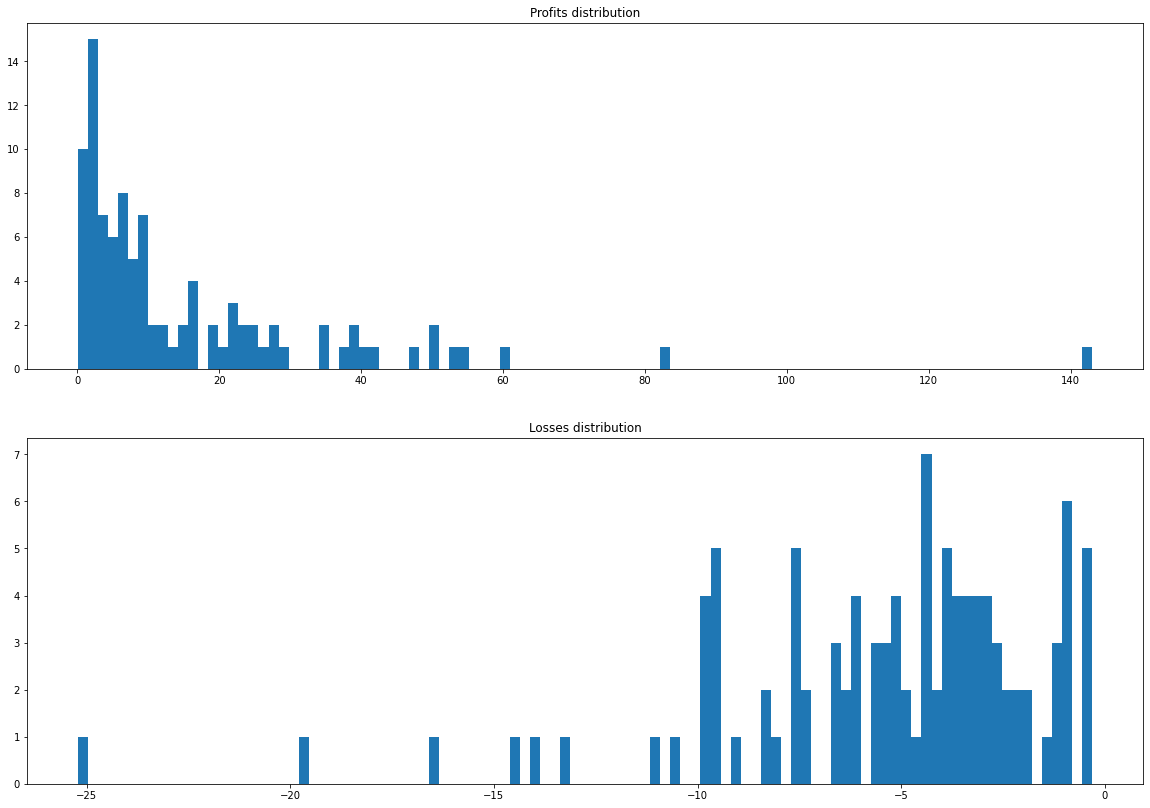

In [5]:
coin_timeframe = 'btc_15m'
df_btc15m = pandas.read_csv(f"backtest_result/backtest_summary_{coin_timeframe}.csv")
result = plot1(df_btc15m, coin_timeframe)
save_goodlist(result, coin_timeframe)
read_goodlist(coin_timeframe)

## BTC 1h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


goodlist_length: [14. 15.  6.  7.  8.  9. 10. 11. 12. 13.]
goodlist_multiplier: [ 9.   9.5 10.  10.5 19.  19.5 20.   7.5  8.   8.5]
kinda_best_length = 15;	kinda_best_multiplier = 20.0
     average_profit  average_loss
405       52.255505    -10.815636
read_goodlist: {'coin_timeframe': 'btc_1h', 'kinda_best_length': 15, 'kinda_best_multiplier': 20.0, 'good_length_list': array([14., 15.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), 'good_multiplier_list': array([ 9. ,  9.5, 10. , 10.5, 19. , 19.5, 20. ,  7.5,  8. ,  8.5])}


{'coin_timeframe': 'btc_1h',
 'kinda_best_length': 15,
 'kinda_best_multiplier': 20.0,
 'good_length_list': array([14., 15.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 'good_multiplier_list': array([ 9. ,  9.5, 10. , 10.5, 19. , 19.5, 20. ,  7.5,  8. ,  8.5])}

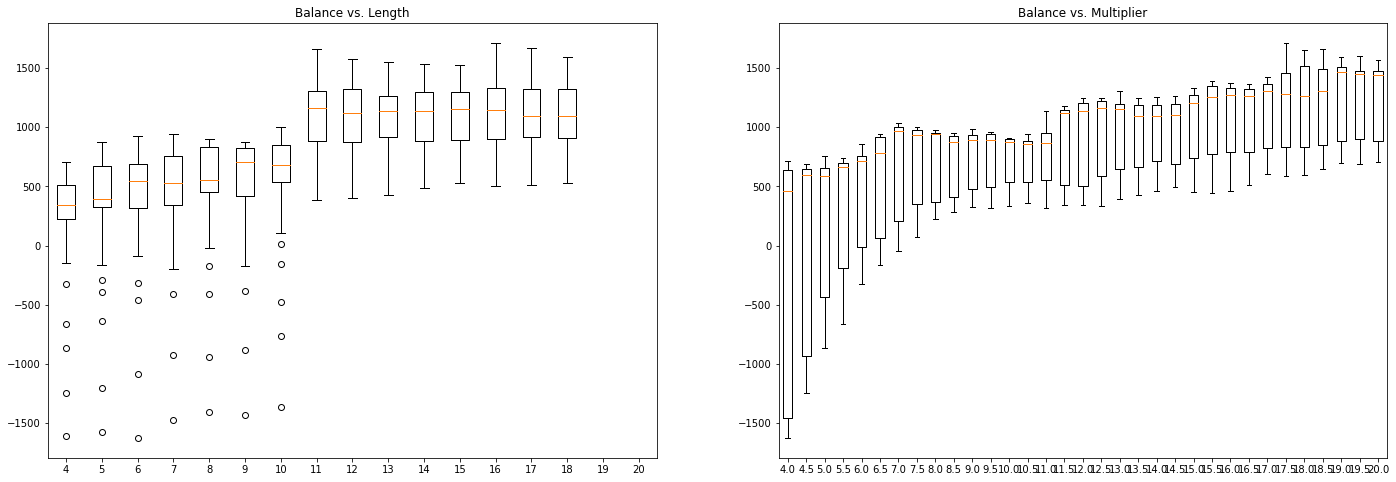

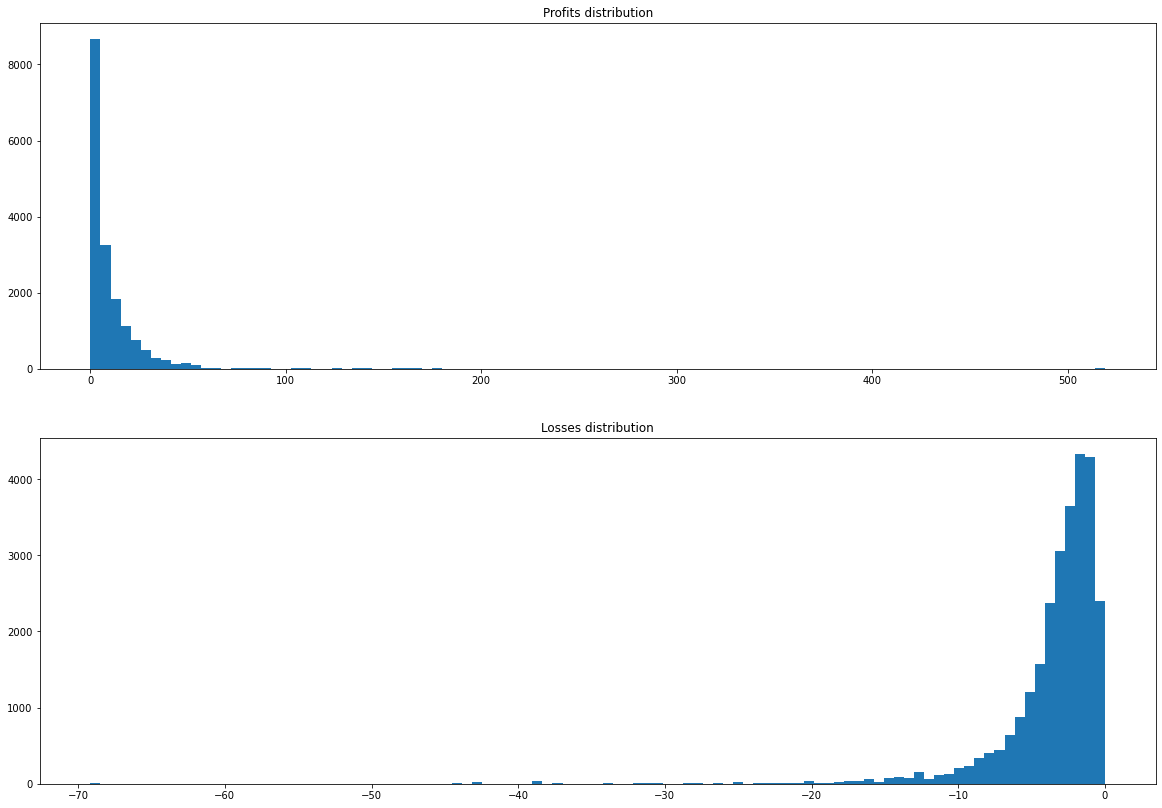

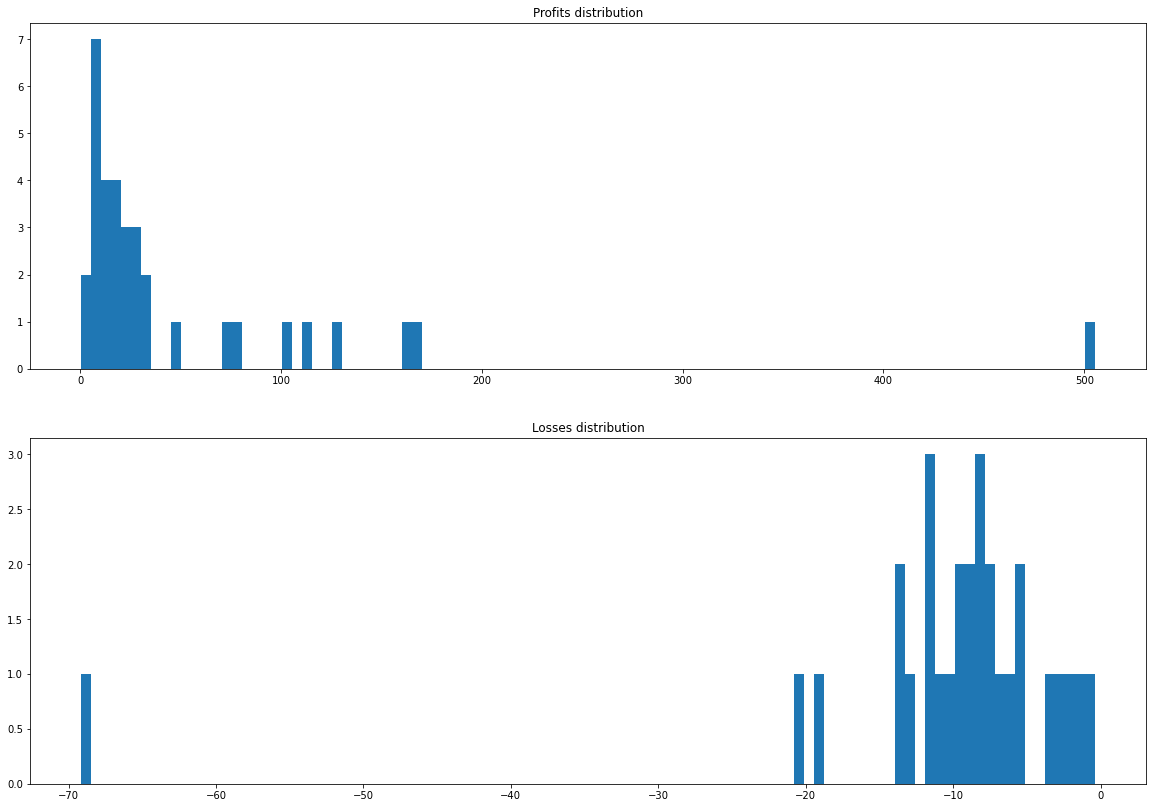

In [7]:
coin_timeframe = 'btc_1h'
df_btc1h = pandas.read_csv(f"backtest_result/backtest_summary_{coin_timeframe}.csv")
result = plot1(df_btc1h, coin_timeframe)
save_goodlist(result, coin_timeframe)
read_goodlist(coin_timeframe)

In [ ]:
df_btc1h.query('config_length==15 & config_multiplier==20')

,coinpair,length_in_days,balance,config_length,config_multiplier,no_of_orders,number_of_profit_order,average_profit,number_of_loss_order,average_loss,avarage_pnl_per_month,profit_amounts,loss_amounts,balance_std
405,btc,3739.333333,1463.033713,15,20.0,63,34,52.255505,29,-10.815636,11.737657,"""[25.570038910505854, 24.048192771084338, 20.2...","""[-69.16666666666667, -7.642857142857146, -13....",1.268436


## BTC 4h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


goodlist_length: [ 4.  5.  6.  7.  8.  9. 10. 11. 18. 17.]
goodlist_multiplier: [4.  4.5 5.  5.5 6.  9.  7.  7.5 8.  8.5]
kinda_best_length = 4;	kinda_best_multiplier = 5.0
    average_profit  average_loss
43       29.751187     -6.240547
read_goodlist: {'coin_timeframe': 'btc_4h', 'kinda_best_length': 4, 'kinda_best_multiplier': 5.0, 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 18., 17.]), 'good_multiplier_list': array([4. , 4.5, 5. , 5.5, 6. , 9. , 7. , 7.5, 8. , 8.5])}


{'coin_timeframe': 'btc_4h',
 'kinda_best_length': 4,
 'kinda_best_multiplier': 5.0,
 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 18., 17.]),
 'good_multiplier_list': array([4. , 4.5, 5. , 5.5, 6. , 9. , 7. , 7.5, 8. , 8.5])}

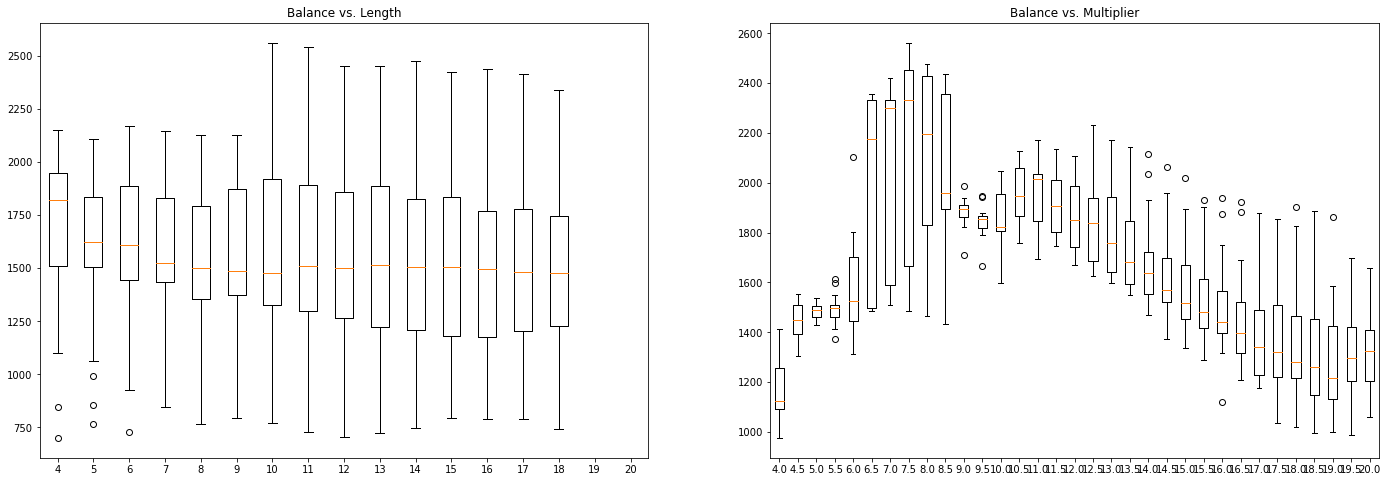

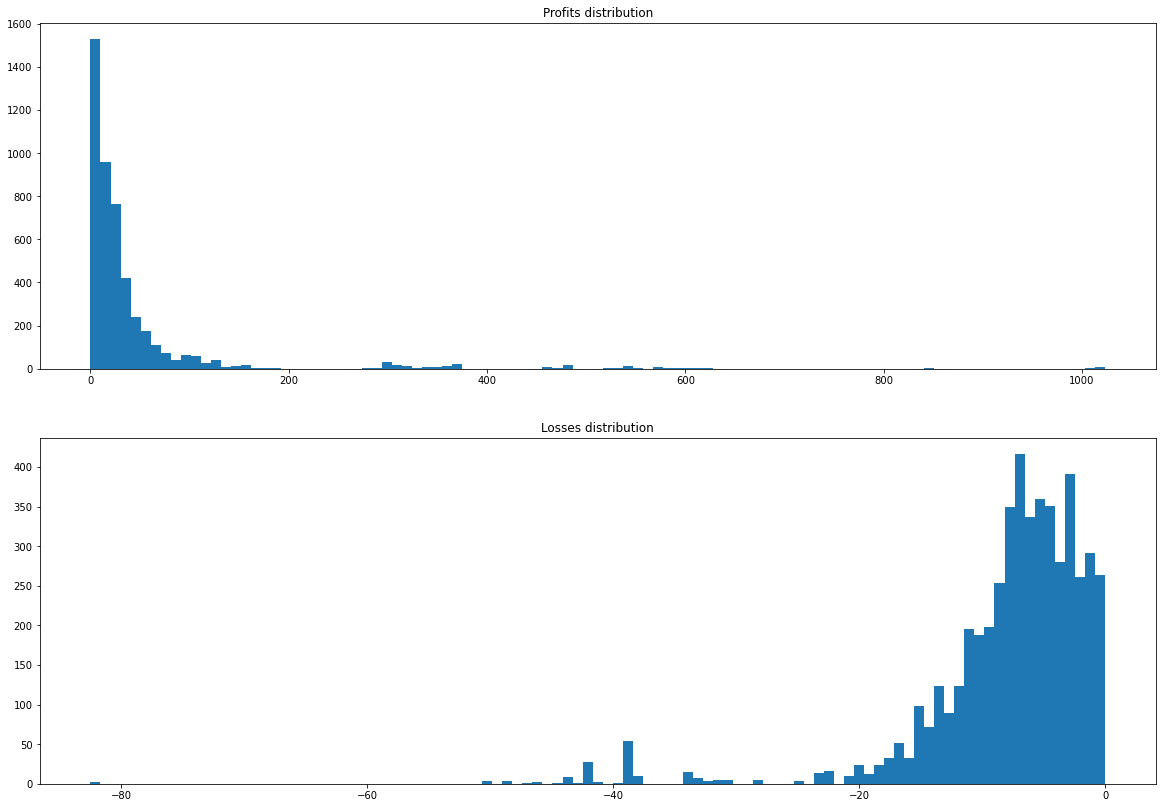

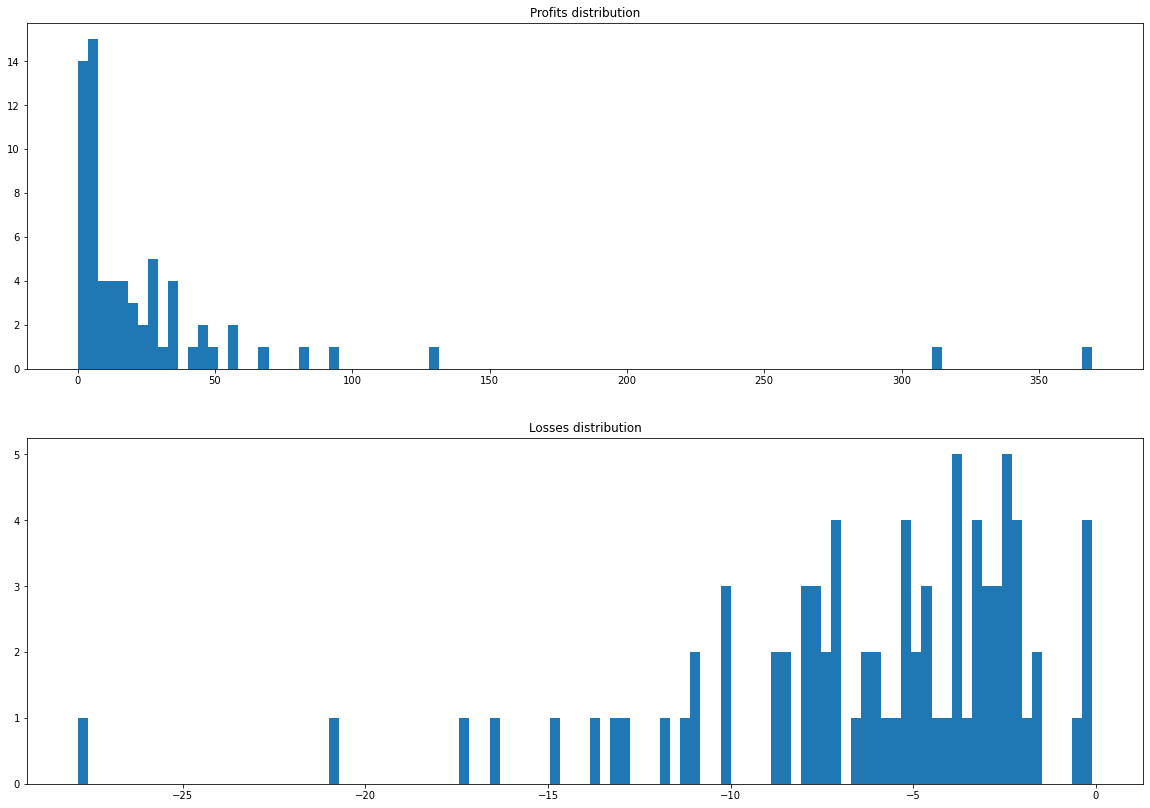

In [8]:
coin_timeframe = 'btc_4h'
df_btc4h = pandas.read_csv(f"backtest_result/backtest_summary_{coin_timeframe}.csv")
result = plot1(df_btc4h, coin_timeframe)
save_goodlist(result, coin_timeframe)
read_goodlist(coin_timeframe)

In [ ]:
df_btc4h.query('config_length==4 & config_multiplier==5')

,coinpair,length_in_days,balance,config_length,config_multiplier,no_of_orders,number_of_profit_order,average_profit,number_of_loss_order,average_loss,avarage_pnl_per_month,profit_amounts,loss_amounts,balance_std
43,btc,3857.833333,1511.355896,4,5.0,150,68,29.751187,82,-6.240547,11.752886,"""[41.16666666666667, 46.16666666666666, 6.5312...","""[-10.138554216867478, -27.88095238095239, -17...",-0.192262


In [ ]:
df_btc4h.query('config_length==4 & config_multiplier==9')


,coinpair,length_in_days,balance,config_length,config_multiplier,no_of_orders,number_of_profit_order,average_profit,number_of_loss_order,average_loss,avarage_pnl_per_month,profit_amounts,loss_amounts,balance_std
51,btc,3857.833333,1985.278361,4,9.0,71,39,56.61529,32,-6.959935,15.43829,"""[41.16666666666667, 32.83333333333333, 4.7427...","""[-9.522556390977451, -4.4215686274509665, -0....",1.018696


# Get Best Configs 
whose returns are in top10 and whose length & multiplier are in the goodlist 

In [12]:
coin_timeframes = [
  'btc_15m',
  'btc_1h',
  'btc_4h',
  ]

for ct in coin_timeframes:
  goodlist = read_goodlist(ct)
  backtest_summary = pandas.read_csv(f"backtest_result/backtest_summary_{ct}.csv")
  backtest_summary.sort_values(by='balance', ascending=False, inplace=True)
  # print(backtest_summary.head(10))
  backtest_summary = backtest_summary[  backtest_summary['config_length'].isin(goodlist['good_length_list']) & 
                                        backtest_summary['config_multiplier'].isin(goodlist['good_multiplier_list'])]
  backtest_summary = backtest_summary.iloc[:10,:]
  backtest_summary.to_csv(f"backtest_result/best_configs_{ct}.csv")
  
  config_list = get_config_list_from_backtest_summary(backtest_summary)
  print(config_list)
  save_in_pkl(config_list, f"backtest_result/config_list_{ct}.pkl")


read_goodlist: {'coin_timeframe': 'btc_15m', 'kinda_best_length': 6, 'kinda_best_multiplier': 10.5, 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 14., 12., 13.]), 'good_multiplier_list': array([ 9. , 10.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5])}
[[7.0, 8.5], [13.0, 7.0], [7.0, 9.0], [6.0, 9.0], [13.0, 7.5], [5.0, 9.0], [7.0, 7.5], [14.0, 7.5], [14.0, 7.0], [8.0, 8.5]]
read_goodlist: {'coin_timeframe': 'btc_1h', 'kinda_best_length': 15, 'kinda_best_multiplier': 20.0, 'good_length_list': array([14., 15.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), 'good_multiplier_list': array([ 9. ,  9.5, 10. , 10.5, 19. , 19.5, 20. ,  7.5,  8. ,  8.5])}
[[11.0, 19.5], [11.0, 19.0], [11.0, 20.0], [13.0, 19.0], [14.0, 19.0], [15.0, 19.0], [13.0, 19.5], [14.0, 19.5], [14.0, 20.0], [13.0, 20.0]]
read_goodlist: {'coin_timeframe': 'btc_4h', 'kinda_best_length': 4, 'kinda_best_multiplier': 5.0, 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 18., 17.]), 'good_multipl

# Backtest the best configs

In [16]:
import backtest

coin = 'btc'
timeframes = ('4h', '1h', '15m' );  length_in_days = (1/6, 1/24, 1/24/4)
trends = ('_recentYear',)  #'_bear1', '_bear2', '_bear3', 
result_recorder = backtest.ResultRecorder()

for trend in trends:
  for timeframe, length_in_day in zip(timeframes, length_in_days):
    print('timeframe =', timeframe)
    config_list = load_from_pkl(f"backtest_result/config_list_{coin}_{timeframe}.pkl")

    df = pandas.read_csv(f"historical_data/{coin}_{timeframe}_original{trend}.csv")
    # Rename columns and drop some to reduce memory weight
    df['timestamp'] = df['time_period_start']
    df['open'] = df['price_open']
    df['high'] = df['price_high']
    df['low'] = df['price_low']
    df['close'] = df['price_close']
    df.drop(['time_period_start', 'time_open', 
            'price_open', 'price_high', 'price_low', 
            'price_close', 'volume_traded', 'trades_count'], axis=1)
    df = df.iloc[::-1].reset_index()
    print('length_of_df =', len(df), end=' ')

    for (length, multiplier) in config_list:
      length = int(length)
      print(f"config = ({length},{multiplier})")
      supertrend_data, balance = backtest.backtest(length, multiplier, result_recorder, df)
        
      result_recorder.add_new_row({
          'coinpair': coin,
          'timeframe': timeframe,
          'length_in_days': length_in_day*len(supertrend_data), 
          'trend': trend,
          'balance': balance, 
          'config_length': length, 
          'config_multiplier': multiplier, 
          'no_of_orders': result_recorder.order_number, 
          'number_of_profit_order': result_recorder.get_profit_order_number(), 
          'average_profit': result_recorder.get_average_profit(), 
          'number_of_loss_order': result_recorder.get_loss_order_number(), 
          'average_loss': result_recorder.get_average_loss(),
          'avarage_pnl_per_month': balance / (length_in_day*len(supertrend_data)) * 30,
          'profit_amounts': f"\"{result_recorder.get_profit_order()}\"",
          'loss_amounts': f"\"{result_recorder.get_loss_order()}\"",
      })
      ## Save trade history
      result_recorder.save_in_csv(f"backtest_result/best_configs_backtest_{ct}_2.csv")  #_{length}_{int(multiplier*10)}
      result_recorder.reset_stats()
    print()


timeframe = 4h
length_of_df = 5861 config = (10,7.5)
config = (11,7.5)
config = (11,8.0)
config = (11,7.0)
config = (17,7.5)
config = (17,8.0)
config = (10,7.0)
config = (18,7.0)
config = (18,8.0)
config = (17,7.0)

timeframe = 1h
length_of_df = 24625 config = (11,19.5)
config = (11,19.0)
config = (11,20.0)
config = (13,19.0)
config = (14,19.0)
config = (15,19.0)
config = (13,19.5)
config = (14,19.5)
config = (14,20.0)
config = (13,20.0)

timeframe = 15m
length_of_df = 89206 config = (7,8.5)
config = (13,7.0)
config = (7,9.0)
config = (6,9.0)
config = (13,7.5)
config = (5,9.0)
config = (7,7.5)
config = (14,7.5)
config = (14,7.0)
config = (8,8.5)

